In [46]:
import rebound
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
from scipy.interpolate import interp1d
import pymc3 as pm
import scipy
from scipy.integrate import quad

plt.style.use('paper.mplstyle')
%matplotlib inline

In [3]:
dfhadden = pd.read_csv("Kepler-23_default_priors.csv", index_col=0)
dfhadden.tail()

,mu0,per0,h0,k0,Tc0,mu1,per1,h1,k1,Tc1,...,e0,mean_long0,pomega1,e1,mean_long1,pomega2,e2,mean_long2,Z12,Z23
249995,0.000003,7.105870,-0.038511,-0.196506,57.031001,0.000006,10.743525,0.032910,-0.196457,55.659821,...,0.200244,6.120452,-1.404821,0.199195,5.147323,-1.075444,0.199238,4.333169,0.057631,0.052884
249996,0.000003,7.106110,-0.069445,0.025974,56.975209,0.000006,10.743671,0.000208,-0.003399,55.525812,...,0.074143,6.171487,-1.509681,0.003406,5.226137,-0.406624,0.062597,4.431526,0.048022,0.047269
249997,0.000004,7.106614,-0.001841,-0.075112,57.111239,0.000004,10.743291,0.044821,-0.081911,55.689775,...,0.075134,6.054789,-1.070109,0.093372,5.129095,-0.580675,0.077984,4.414196,0.039443,0.029061
249998,0.000003,7.106508,-0.087985,0.084049,56.927508,0.000004,10.743239,-0.016223,0.039809,55.475669,...,0.121678,6.216482,1.957768,0.042988,5.254157,0.894684,0.026970,4.517402,0.048540,0.025173
249999,0.000004,7.106154,-0.122730,-0.000055,56.853333,0.000009,10.743234,-0.046245,-0.023290,55.364239,...,0.122730,6.279559,-2.675062,0.051779,5.319310,-2.470655,0.004345,4.557613,0.045531,0.029906


In [4]:
df = pd.read_csv('Kepler-23_default_priors_uniform.csv', index_col=0)
df.tail()

,sim,Mstar,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,mu1,mu2,mu3,mu1+mu2,mu2+mu3,mutot,t_instability,nbodystable,spockprob
27048,1999380.0,0.880613,0.201449,0.139535,0.102941,0.132488,0.198727,0.155031,0.014555,2.729311e-06,0.000012,0.000003,0.000015,0.000015,0.000018,5.358731e+04,0.0,0.007788
27049,1999466.0,1.214257,0.028842,0.012843,0.021864,0.008439,0.039781,0.010983,0.022669,8.367568e-07,0.000042,0.000007,0.000043,0.000049,0.000050,1.000000e+09,1.0,0.796429
27050,1999693.0,1.225737,0.075410,0.120734,0.066761,0.111895,0.088874,0.108052,0.175515,9.338099e-06,0.000078,0.000004,0.000087,0.000081,0.000091,6.319852e+04,0.0,0.005343
27051,1999943.0,1.083352,0.130139,0.262373,0.077109,0.180838,0.224166,0.236365,0.140135,1.474248e-06,0.000006,0.000018,0.000007,0.000024,0.000025,2.133985e+04,0.0,0.006733
27052,1999969.0,1.159434,0.046016,0.032291,0.051997,0.031372,0.095140,0.020418,0.050637,3.549245e-06,0.000037,0.000085,0.000040,0.000122,0.000125,5.152893e+05,0.0,0.012635


In [5]:
dfvanEylen = pd.read_csv('Kepler-23_vanEylen.csv', index_col=0)
dfvanEylen.tail()

,ID,Mstar,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,mu1,mu2,mu3,mu1+mu2,mu2+mu3,mutot
39995,39995.0,1.078,0.255002,0.219570,0.241360,0.209458,0.127092,0.284903,0.147279,0.000017,0.000040,0.000017,0.000058,0.000057,0.000074
39996,39996.0,1.078,0.167373,0.060257,0.100118,0.029407,0.262542,0.001692,0.130529,0.000008,0.000036,0.000010,0.000044,0.000046,0.000054
39997,39997.0,1.078,0.312808,0.203716,0.270535,0.179107,0.392362,0.198785,0.305235,0.000019,0.000037,0.000023,0.000056,0.000060,0.000079
39998,39998.0,1.078,0.427064,0.347577,0.235449,0.420195,0.124926,0.495464,0.299385,0.000012,0.000021,0.000017,0.000033,0.000038,0.000050
39999,39999.0,1.078,0.622926,0.460633,0.089570,0.727851,0.023163,0.722732,0.518803,0.000013,0.000016,0.000012,0.000029,0.000028,0.000040


In [67]:
def calcHPDI(vals, interval, x0, weights=None):
    '''
    Fit a gaussian KDE, find max likelihood, and calculate 
    minimum interval that holds `interval` percentage of the distribution.
    This is what Hadden 2017 quote

        vals : array of values
        interval: float for size of interval
        x0: initial guess for max likelihood
    '''
    kde = scipy.stats.gaussian_kde(vals, weights=weights)
    maxlike = scipy.optimize.fmin(lambda x: -kde(x), x0=x0)[0]
    
    sample = kde.resample(10000) # need to do this step in case we need to weight the vals by weights (for SPOCK probs)
    samplecut = sample[sample > 0]

    low, high = pm.stats.hpd(samplecut, credible_interval=interval)
    print('{0:.1f}% interval=[{1:.3f},{2:.3f}]'.format(interval*100, low, high))
    print('{0:.4f} + {1:.4f} - {2:.4f}'.format(maxlike, high-maxlike, maxlike-low))
    return maxlike, high-maxlike, maxlike-low

In [79]:
def plotposterior(vals, interval, x0, weights=None, range=[0,1]):
    fig, ax = plt.subplots()

    ax.hist(vals, alpha=0.5, density=True, weights=weights, bins=100, range=range)
    kde = scipy.stats.gaussian_kde(vals, weights=weights)
    xs = np.linspace(0,1,1000)
    ax.plot(xs, kde(xs))
    
    maxlike, errhigh, errlow = calcHPDI(vals, interval, x0, weights=weights)
    ax.axvline(maxlike-errlow, linestyle='--', c='k', alpha=0.3)
    ax.axvline(maxlike+errhigh, linestyle='--', c='k', alpha=0.3)
    ax.axvline(maxlike, c='k', alpha=0.3)
    ax.set_xlim(range)

Optimization terminated successfully.
         Current function value: -11.351687
         Iterations: 13
         Function evaluations: 26
0.0313 + 0.0476 - 0.0232


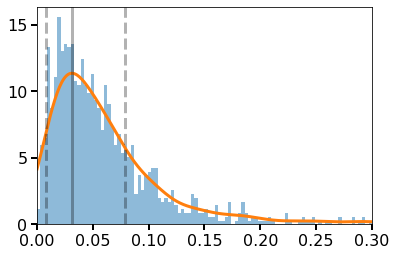

In [55]:
plotposterior(df[df['nbodystable']==1].Z12, 0.683, 0.1, range=[0,0.3])

Optimization terminated successfully.
         Current function value: -7.817870
         Iterations: 13
         Function evaluations: 26
68.3% interval=[0.001,0.121]
0.0316 + 0.0892 - 0.0305


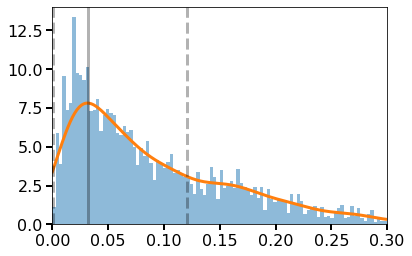

In [80]:
plotposterior(df.Z12, 0.683, 0.1, weights=df.spockprob, range=[0,0.3])

Optimization terminated successfully.
         Current function value: -25.432995
         Iterations: 17
         Function evaluations: 35
0.0179 + 0.0242 - 0.0059


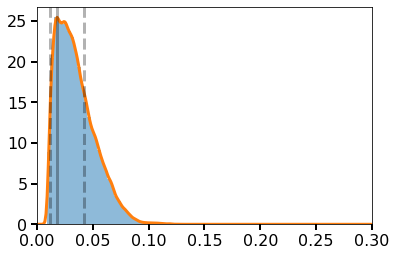

In [56]:
plotposterior(dfhadden.Z12, 0.683, 0.1, range=[0,0.3])

# High Z23 values mess up KDE so exclude them

Optimization terminated successfully.
         Current function value: -18.844240
         Iterations: 13
         Function evaluations: 26
68.3% interval=[0.008,0.051]
0.0245 + 0.0264 - 0.0170


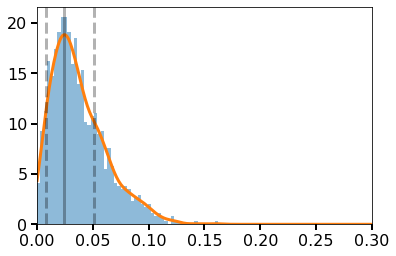

In [91]:
plotposterior(df[(df['nbodystable']==1) & (df['Z23']<0.4)].Z23, 0.683, 0.1, range=[0,0.3])

Optimization terminated successfully.
         Current function value: -18.850297
         Iterations: 13
         Function evaluations: 26
68.3% interval=[0.009,0.051]
0.0227 + 0.0281 - 0.0141


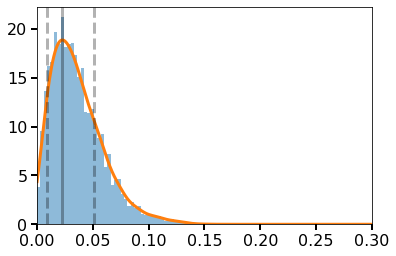

In [83]:
plotposterior(df.Z23, 0.683, 0.1, weights=df.spockprob, range=[0,0.3])

Optimization terminated successfully.
         Current function value: -27.430494
         Iterations: 14
         Function evaluations: 28
68.3% interval=[0.008,0.035]
0.0214 + 0.0135 - 0.0135


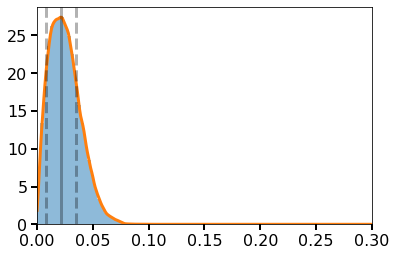

In [84]:
plotposterior(dfhadden.Z23, 0.683, 0.1, range=[0,0.3])

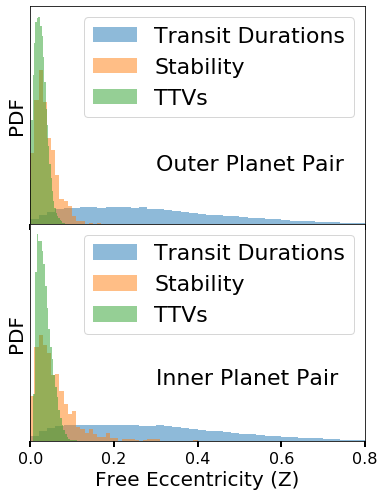

In [139]:
stable = df['nbodystable'] == 1
fig, axarr = plt.subplots(nrows=2, figsize=(6,8))
plt.subplots_adjust(hspace=0)

axarr[0].hist(dfvanEylen.Z23, alpha=0.5, density=True, label="Transit Durations", bins=50, range=[0,1])
_, bins, _ = axarr[0].hist(df[stable].Z23, alpha=0.5, density=True, label="Stability", bins=50, range=[0,0.5])
axarr[0].hist(dfhadden.Z23, alpha=0.5, density=True, bins=30, label="TTVs")
axarr[0].set_xlim([0,0.8])
axarr[0].text(0.3,7, 'Outer Planet Pair', fontsize=22)
axarr[0].set_xticklabels([])
axarr[0].axes.yaxis.set_ticks([])
axarr[0].set_ylabel('PDF')
axarr[0].legend(fontsize=22)


axarr[1].hist(dfvanEylen.Z12, alpha=0.5, density=True, label="Transit Durations", bins=50, range=[0,1])
_, bins, _ = axarr[1].hist(df[stable].Z12, alpha=0.5, density=True, label="Stability", bins=50, range=[0,0.5])
axarr[1].hist(dfhadden.Z12, alpha=0.5, density=True, bins=30, label="TTVs")
axarr[1].set_xlim([0,0.8])
axarr[1].text(0.3,7, 'Inner Planet Pair', fontsize=22)
axarr[1].axes.yaxis.set_ticks([])
axarr[1].set_xlabel('Free Eccentricity (Z)')
axarr[1].set_ylabel('PDF')
axarr[1].legend(fontsize=22)

fig.savefig('methodcomparison.pdf', bbox_inches='tight')